<a href="https://colab.research.google.com/github/yulinlina/MedMnist/blob/main/Swin_nopre_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=a945015176447796a797332df80c5ef8c13fc234f760ee2c8960cbe636627dae
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [ ]:
!pip install swin-transformer-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.1 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset

In [ ]:
data_flag = 'dermamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.Resize((224,224))
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /roo

In [ ]:
# visualization

train_dataset.montage(length=1)

/usr/local/lib/python3.9/dist-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


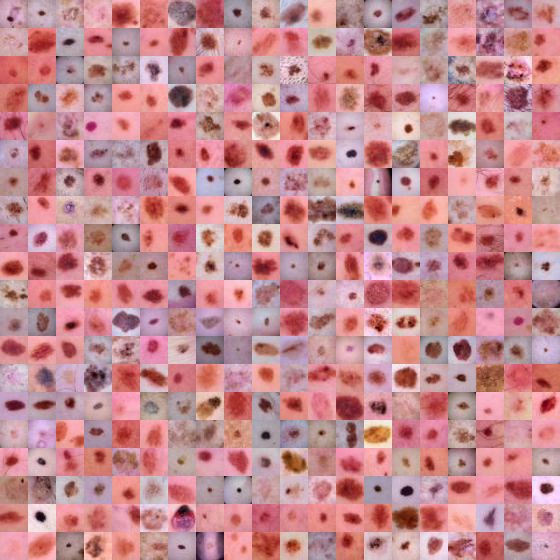

In [ ]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)

import torch
from swin_transformer_pytorch import SwinTransformer

# net = SwinTransformer(
#     hidden_dim=96,
#     layers=(2, 2, 6, 2),
#     heads=(3, 6, 12, 24),
#     channels=3,
#     num_classes=3,
#     head_dim=32,
#     window_size=7,
#     downscaling_factors=(4, 2, 2, 2),
#     relative_pos_embedding=True
# )
# dummy_x = torch.randn(1, 3, 224, 224)
# logits = net(dummy_x)  # (1,3)


#model = Net(in_channels=n_channels, num_classes=n_classes)
# model = ResNet18(in_channels=n_channels, num_classes=n_classes)
# model =  resnet50(pretrained=False, num_classes=n_classes) if resize else ResNet50(in_channels=n_channels, num_classes=n_classes) 
 

model = SwinTransformer(hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=n_channels,
    num_classes=n_classes,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True)

print(model)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    


SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none

In [ ]:

def test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device) 
            targets = targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy() 
        y_score = y_score.detach().cpu().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

## Next, we can start to train and evaluate!

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
NUM_EPOCHS=30
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        model.to(device) 
        inputs = inputs.to(device) 
        targets = targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    test('test')

100%|██████████| 55/55 [01:37<00:00,  1.77s/it]


test  auc: 0.772  acc:0.675


100%|██████████| 55/55 [01:37<00:00,  1.78s/it]


test  auc: 0.808  acc:0.668


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.832  acc:0.673


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.841  acc:0.672


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.850  acc:0.678


100%|██████████| 55/55 [01:37<00:00,  1.78s/it]


test  auc: 0.849  acc:0.654


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.863  acc:0.693


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.866  acc:0.683


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.874  acc:0.688


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.877  acc:0.699


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.884  acc:0.701


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.889  acc:0.704


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.893  acc:0.696


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.897  acc:0.710


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.898  acc:0.714


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.895  acc:0.695


100%|██████████| 55/55 [01:37<00:00,  1.78s/it]


test  auc: 0.901  acc:0.717


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.899  acc:0.717


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.901  acc:0.722


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.905  acc:0.716


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.903  acc:0.717


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.907  acc:0.720


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.903  acc:0.707


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.908  acc:0.731


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.908  acc:0.720


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.905  acc:0.708


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.907  acc:0.713


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.907  acc:0.725


100%|██████████| 55/55 [01:38<00:00,  1.79s/it]


test  auc: 0.912  acc:0.721


100%|██████████| 55/55 [01:38<00:00,  1.78s/it]


test  auc: 0.910  acc:0.731


In [ ]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.926  acc:0.751
test  auc: 0.910  acc:0.731


# We then check a 3D dataset

In [ ]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/three/.medmnist/organmnist3d.npz


In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

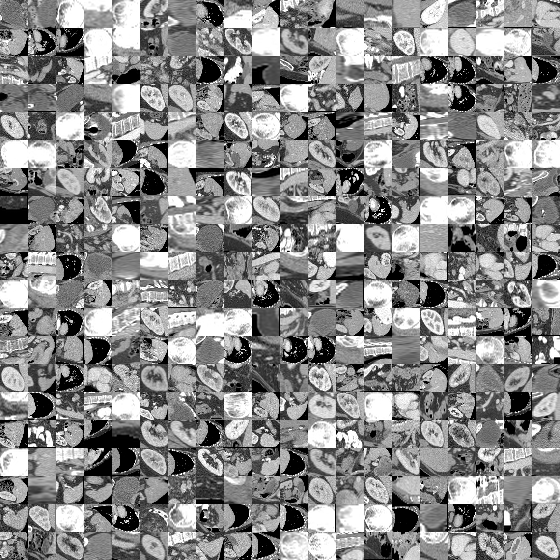

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)